# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.discrete, source=Source.majority, past=Past.all, durl=Durl.exclude_past, max_distance=1)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 7196 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.all, durl=Durl.exclude_past, max_distance=1)


  0% (   1 of 7196) |                     | Elapsed Time: 0:00:05 ETA:  10:24:57

  0% (  46 of 7196) |                      | Elapsed Time: 0:00:06 ETA:  0:02:34

  1% (  90 of 7196) |                      | Elapsed Time: 0:00:07 ETA:  0:02:49

  2% ( 164 of 7196) |                      | Elapsed Time: 0:00:08 ETA:  0:02:12

  2% ( 180 of 7196) |                      | Elapsed Time: 0:00:08 ETA:  0:02:08

  3% ( 256 of 7196) |                      | Elapsed Time: 0:00:09 ETA:  0:01:55

  3% ( 270 of 7196) |                      | Elapsed Time: 0:00:09 ETA:  0:01:55

  4% ( 341 of 7196) |#                     | Elapsed Time: 0:00:10 ETA:  0:01:49

  5% ( 360 of 7196) |#                     | Elapsed Time: 0:00:11 ETA:  0:01:48

  6% ( 450 of 7196) |#                     | Elapsed Time: 0:00:12 ETA:  0:01:27

  7% ( 525 of 7196) |#                     | Elapsed Time: 0:00:13 ETA:  0:01:25

  7% ( 540 of 7196) |#                     | Elapsed Time: 0:00:13 ETA:  0:01:26

  8% ( 598 of 7196) |#                     | Elapsed Time: 0:00:14 ETA:  0:01:28

  8% ( 630 of 7196) |#                     | Elapsed Time: 0:00:15 ETA:  0:01:30

  9% ( 688 of 7196) |##                    | Elapsed Time: 0:00:16 ETA:  0:01:30

 10% ( 720 of 7196) |##                    | Elapsed Time: 0:00:16 ETA:  0:01:29

 10% ( 790 of 7196) |##                    | Elapsed Time: 0:00:17 ETA:  0:01:28

 11% ( 810 of 7196) |##                    | Elapsed Time: 0:00:17 ETA:  0:01:29

 12% ( 883 of 7196) |##                    | Elapsed Time: 0:00:18 ETA:  0:01:27

 12% ( 900 of 7196) |##                    | Elapsed Time: 0:00:19 ETA:  0:01:28

 13% ( 990 of 7196) |###                   | Elapsed Time: 0:00:20 ETA:  0:01:22

 14% (1051 of 7196) |###                   | Elapsed Time: 0:00:21 ETA:  0:01:23

 15% (1080 of 7196) |###                   | Elapsed Time: 0:00:21 ETA:  0:01:18

 16% (1152 of 7196) |###                   | Elapsed Time: 0:00:22 ETA:  0:01:18

 16% (1170 of 7196) |###                   | Elapsed Time: 0:00:22 ETA:  0:01:18

 17% (1239 of 7196) |###                   | Elapsed Time: 0:00:23 ETA:  0:01:17

 17% (1260 of 7196) |###                   | Elapsed Time: 0:00:24 ETA:  0:01:17

 18% (1350 of 7196) |####                  | Elapsed Time: 0:00:25 ETA:  0:01:15

 20% (1440 of 7196) |####                  | Elapsed Time: 0:00:26 ETA:  0:01:09

 20% (1477 of 7196) |####                  | Elapsed Time: 0:00:27 ETA:  0:01:18

 21% (1530 of 7196) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:16

 22% (1586 of 7196) |####                  | Elapsed Time: 0:00:29 ETA:  0:01:19

 22% (1620 of 7196) |####                  | Elapsed Time: 0:00:29 ETA:  0:01:19

 23% (1710 of 7196) |#####                 | Elapsed Time: 0:00:30 ETA:  0:01:17

 25% (1800 of 7196) |#####                 | Elapsed Time: 0:00:31 ETA:  0:01:16

 26% (1875 of 7196) |#####                 | Elapsed Time: 0:00:32 ETA:  0:01:13

 26% (1889 of 7196) |#####                 | Elapsed Time: 0:00:33 ETA:  0:01:06

 27% (1961 of 7196) |#####                 | Elapsed Time: 0:00:34 ETA:  0:01:05

 27% (1979 of 7196) |######                | Elapsed Time: 0:00:34 ETA:  0:01:01

 28% (2051 of 7196) |######                | Elapsed Time: 0:00:35 ETA:  0:01:00

 28% (2069 of 7196) |######                | Elapsed Time: 0:00:35 ETA:  0:01:01

 29% (2138 of 7196) |######                | Elapsed Time: 0:00:36 ETA:  0:01:02

 30% (2159 of 7196) |######                | Elapsed Time: 0:00:36 ETA:  0:01:03

 31% (2249 of 7196) |######                | Elapsed Time: 0:00:38 ETA:  0:01:02

 32% (2339 of 7196) |#######               | Elapsed Time: 0:00:39 ETA:  0:00:59

 33% (2415 of 7196) |#######               | Elapsed Time: 0:00:40 ETA:  0:00:57

 33% (2429 of 7196) |#######               | Elapsed Time: 0:00:40 ETA:  0:00:57

 34% (2496 of 7196) |#######               | Elapsed Time: 0:00:41 ETA:  0:00:58

 35% (2519 of 7196) |#######               | Elapsed Time: 0:00:41 ETA:  0:00:56

 36% (2591 of 7196) |#######               | Elapsed Time: 0:00:42 ETA:  0:00:56

 36% (2609 of 7196) |#######               | Elapsed Time: 0:00:43 ETA:  0:00:57

 37% (2679 of 7196) |########              | Elapsed Time: 0:00:44 ETA:  0:00:56

 37% (2699 of 7196) |########              | Elapsed Time: 0:00:44 ETA:  0:00:56

 38% (2767 of 7196) |########              | Elapsed Time: 0:00:45 ETA:  0:00:56

 38% (2789 of 7196) |########              | Elapsed Time: 0:00:45 ETA:  0:00:57

 40% (2879 of 7196) |########              | Elapsed Time: 0:00:46 ETA:  0:00:52

 41% (2969 of 7196) |#########             | Elapsed Time: 0:00:47 ETA:  0:00:49

 42% (3059 of 7196) |#########             | Elapsed Time: 0:00:49 ETA:  0:00:47

 43% (3149 of 7196) |#########             | Elapsed Time: 0:00:50 ETA:  0:00:43

 44% (3228 of 7196) |#########             | Elapsed Time: 0:00:51 ETA:  0:00:42

 45% (3239 of 7196) |#########             | Elapsed Time: 0:00:51 ETA:  0:00:50

 46% (3312 of 7196) |##########            | Elapsed Time: 0:00:53 ETA:  0:00:49

 46% (3329 of 7196) |##########            | Elapsed Time: 0:00:53 ETA:  0:00:51

 47% (3398 of 7196) |##########            | Elapsed Time: 0:00:54 ETA:  0:00:50

 47% (3419 of 7196) |##########            | Elapsed Time: 0:00:54 ETA:  0:00:51

 48% (3492 of 7196) |##########            | Elapsed Time: 0:00:55 ETA:  0:00:49

 48% (3509 of 7196) |##########            | Elapsed Time: 0:00:55 ETA:  0:00:51

 50% (3599 of 7196) |###########           | Elapsed Time: 0:00:56 ETA:  0:00:49

 51% (3688 of 7196) |###########           | Elapsed Time: 0:00:57 ETA:  0:00:36

 52% (3778 of 7196) |###########           | Elapsed Time: 0:00:59 ETA:  0:00:32

 53% (3853 of 7196) |###########           | Elapsed Time: 0:01:00 ETA:  0:00:31

 53% (3868 of 7196) |###########           | Elapsed Time: 0:01:00 ETA:  0:00:32

 55% (3958 of 7196) |############          | Elapsed Time: 0:01:01 ETA:  0:00:32

 56% (4048 of 7196) |############          | Elapsed Time: 0:01:02 ETA:  0:00:32

 57% (4120 of 7196) |############          | Elapsed Time: 0:01:03 ETA:  0:00:32

 57% (4138 of 7196) |############          | Elapsed Time: 0:01:03 ETA:  0:00:33

 58% (4208 of 7196) |############          | Elapsed Time: 0:01:04 ETA:  0:00:33

 58% (4228 of 7196) |############          | Elapsed Time: 0:01:05 ETA:  0:00:33

 59% (4302 of 7196) |#############         | Elapsed Time: 0:01:06 ETA:  0:00:30

 60% (4318 of 7196) |#############         | Elapsed Time: 0:01:06 ETA:  0:00:31

 61% (4408 of 7196) |#############         | Elapsed Time: 0:01:07 ETA:  0:00:31

 62% (4498 of 7196) |#############         | Elapsed Time: 0:01:08 ETA:  0:00:27

 63% (4573 of 7196) |#############         | Elapsed Time: 0:01:09 ETA:  0:00:26

 63% (4588 of 7196) |##############        | Elapsed Time: 0:01:09 ETA:  0:00:25

 64% (4661 of 7196) |##############        | Elapsed Time: 0:01:10 ETA:  0:00:25

 65% (4678 of 7196) |##############        | Elapsed Time: 0:01:11 ETA:  0:00:24

 66% (4768 of 7196) |##############        | Elapsed Time: 0:01:12 ETA:  0:00:22

 67% (4858 of 7196) |##############        | Elapsed Time: 0:01:13 ETA:  0:00:21

 68% (4932 of 7196) |###############       | Elapsed Time: 0:01:14 ETA:  0:00:21

 68% (4948 of 7196) |###############       | Elapsed Time: 0:01:14 ETA:  0:00:22

 70% (5038 of 7196) |###############       | Elapsed Time: 0:01:15 ETA:  0:00:19

 70% (5105 of 7196) |###############       | Elapsed Time: 0:01:17 ETA:  0:00:20

 71% (5128 of 7196) |###############       | Elapsed Time: 0:01:17 ETA:  0:00:22

 72% (5218 of 7196) |###############       | Elapsed Time: 0:01:18 ETA:  0:00:20

 73% (5308 of 7196) |################      | Elapsed Time: 0:01:19 ETA:  0:00:17

 75% (5398 of 7196) |################      | Elapsed Time: 0:01:20 ETA:  0:00:15

 76% (5487 of 7196) |################      | Elapsed Time: 0:01:21 ETA:  0:00:09

 77% (5577 of 7196) |#################     | Elapsed Time: 0:01:22 ETA:  0:00:06

 77% (5608 of 7196) |#################     | Elapsed Time: 0:01:23 ETA:  0:00:16

 78% (5667 of 7196) |#################     | Elapsed Time: 0:01:24 ETA:  0:00:17

 80% (5757 of 7196) |#################     | Elapsed Time: 0:01:25 ETA:  0:00:16

 81% (5847 of 7196) |#################     | Elapsed Time: 0:01:26 ETA:  0:00:15

 82% (5937 of 7196) |##################    | Elapsed Time: 0:01:28 ETA:  0:00:14

 83% (6027 of 7196) |##################    | Elapsed Time: 0:01:29 ETA:  0:00:02

 84% (6094 of 7196) |##################    | Elapsed Time: 0:01:30 ETA:  0:00:04

 85% (6117 of 7196) |##################    | Elapsed Time: 0:01:30 ETA:  0:00:03

 86% (6207 of 7196) |##################    | Elapsed Time: 0:01:31 ETA:  0:00:02

 87% (6297 of 7196) |###################   | Elapsed Time: 0:01:32 ETA:  0:00:02

 88% (6387 of 7196) |###################   | Elapsed Time: 0:01:34 ETA:  0:00:01

 90% (6477 of 7196) |###################   | Elapsed Time: 0:01:35 ETA:  0:00:00

 90% (6547 of 7196) |####################  | Elapsed Time: 0:01:36 ETA:  0:00:00

 91% (6567 of 7196) |####################  | Elapsed Time: 0:01:36 ETA:  0:00:00

 92% (6657 of 7196) |####################  | Elapsed Time: 0:01:37 ETA:  0:00:00

 93% (6747 of 7196) |####################  | Elapsed Time: 0:01:38 ETA:  0:00:00

 94% (6824 of 7196) |####################  | Elapsed Time: 0:01:39 ETA:  0:00:00

 95% (6837 of 7196) |####################  | Elapsed Time: 0:01:39 ETA:  0:00:00

 96% (6927 of 7196) |##################### | Elapsed Time: 0:01:41 ETA:  0:00:00

 97% (7017 of 7196) |##################### | Elapsed Time: 0:01:42 ETA:  0:00:00

 98% (7107 of 7196) |##################### | Elapsed Time: 0:01:43 ETA:  0:00:00

 99% (7175 of 7196) |##################### | Elapsed Time: 0:01:44 ETA:  0:00:00

100% (7196 of 7196) |######################| Elapsed Time: 0:01:44 Time: 0:01:44


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

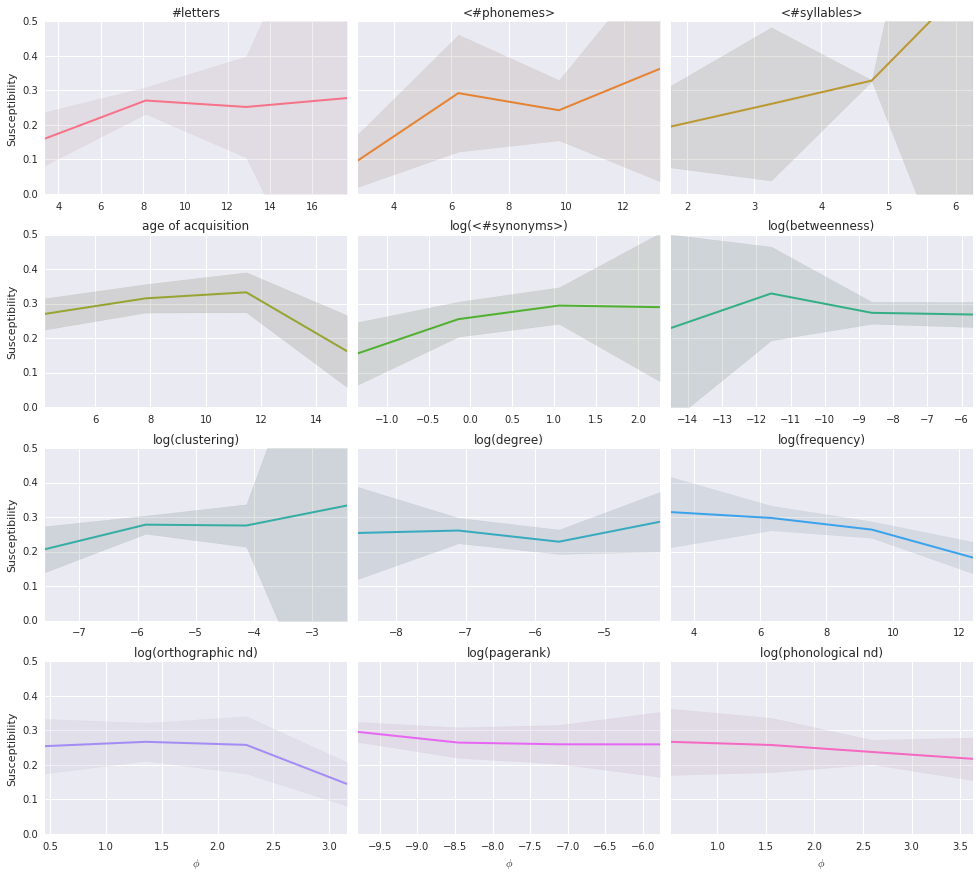

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

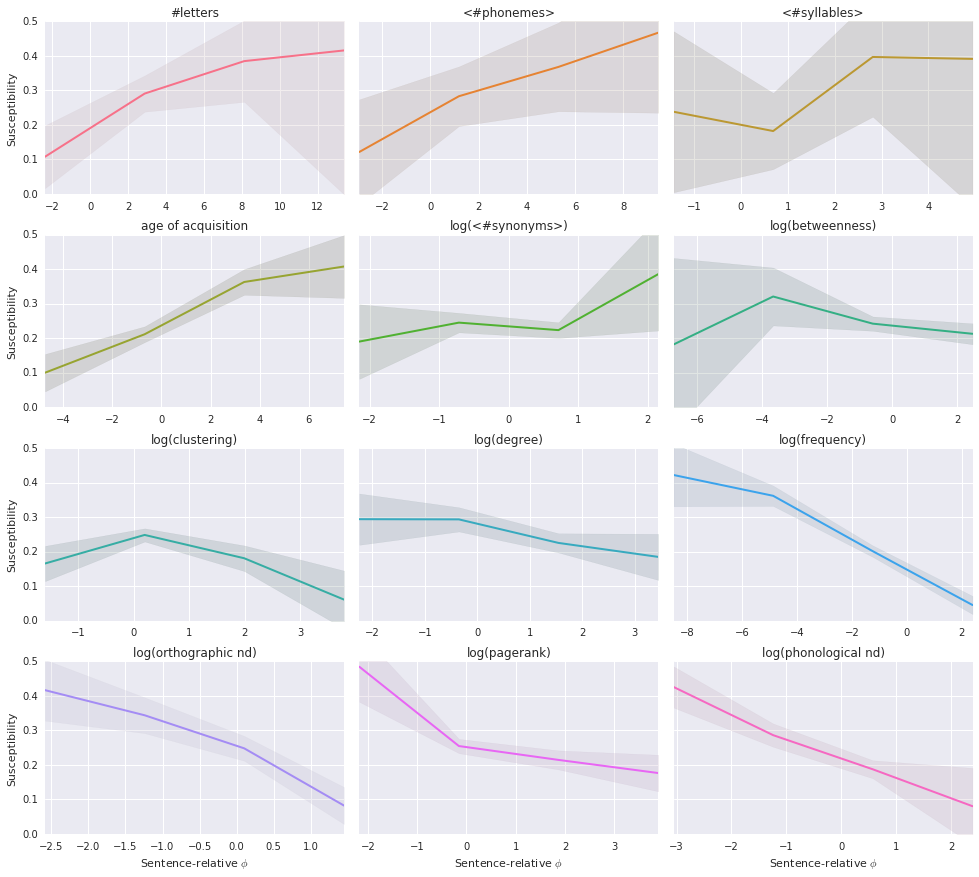

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

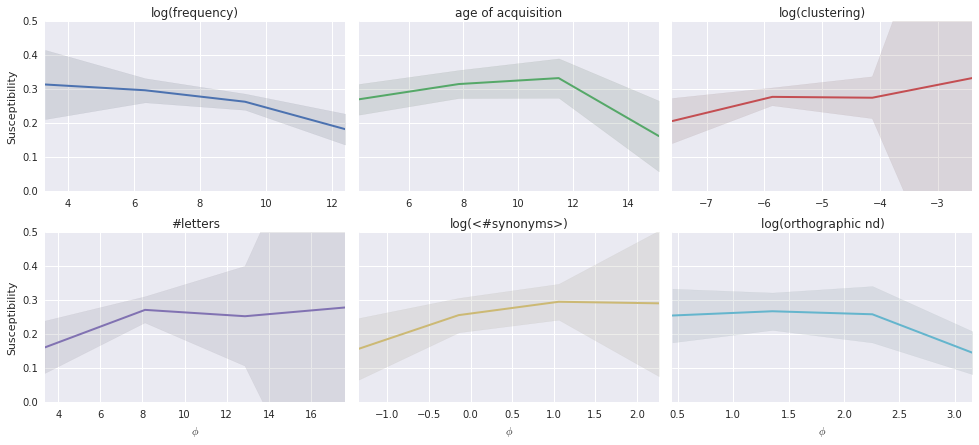

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

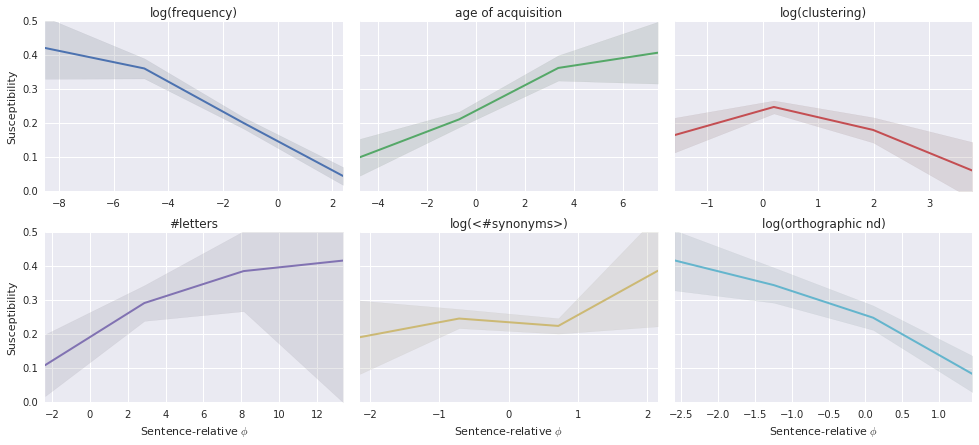

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

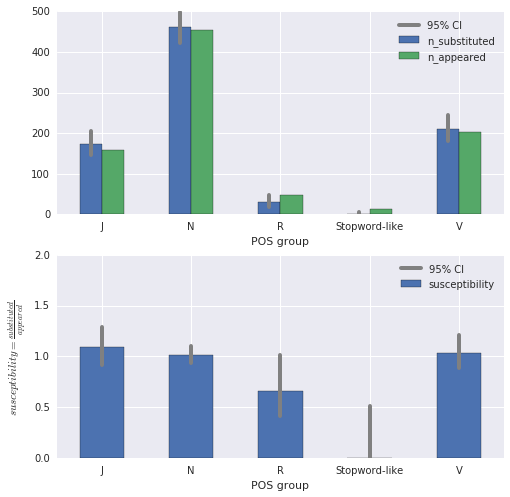

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

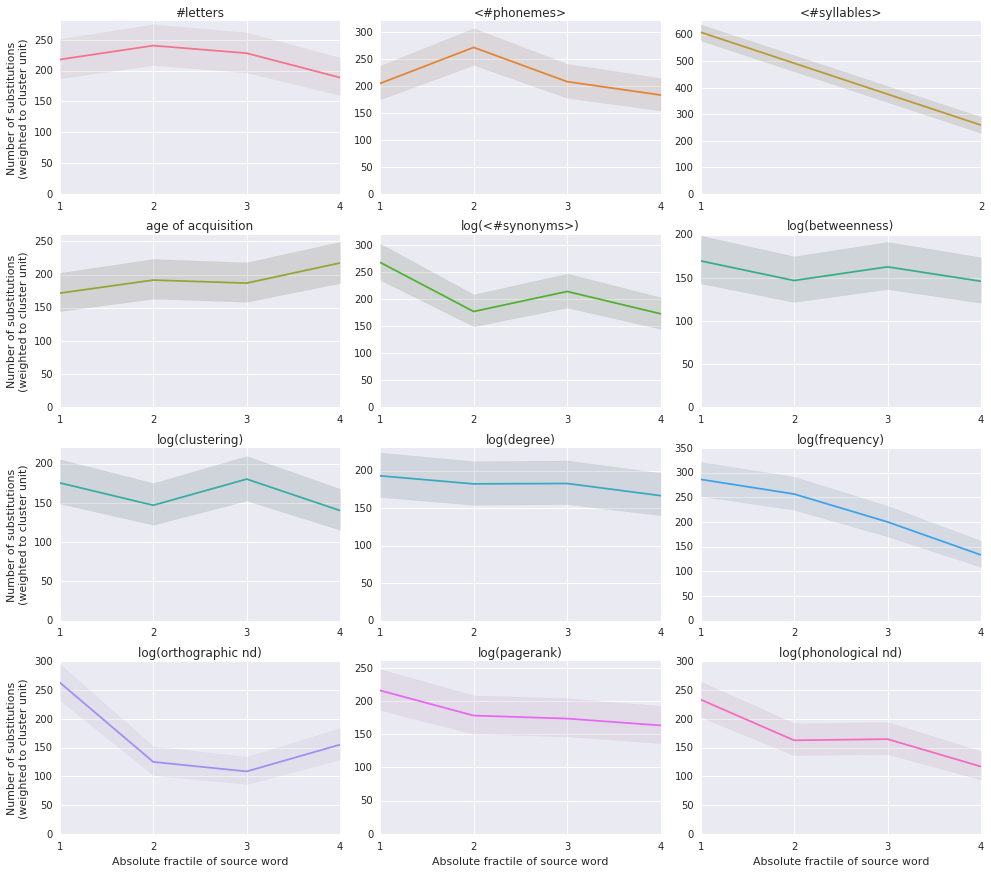

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

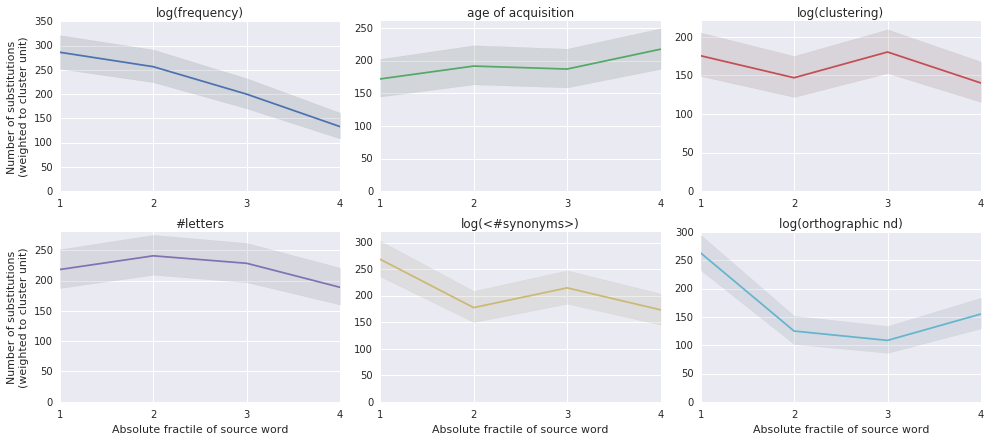

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (  64 of 7196) |                      | Elapsed Time: 0:00:01 ETA:  0:01:52

  1% (  90 of 7196) |                      | Elapsed Time: 0:00:01 ETA:  0:01:50

  1% ( 143 of 7196) |                      | Elapsed Time: 0:00:02 ETA:  0:02:06

  2% ( 180 of 7196) |                      | Elapsed Time: 0:00:03 ETA:  0:02:09

  3% ( 235 of 7196) |                      | Elapsed Time: 0:00:04 ETA:  0:02:08

  3% ( 270 of 7196) |                      | Elapsed Time: 0:00:04 ETA:  0:02:09

  4% ( 315 of 7196) |                      | Elapsed Time: 0:00:05 ETA:  0:02:13

  5% ( 360 of 7196) |#                     | Elapsed Time: 0:00:06 ETA:  0:02:13

  5% ( 408 of 7196) |#                     | Elapsed Time: 0:00:07 ETA:  0:02:13

  6% ( 450 of 7196) |#                     | Elapsed Time: 0:00:08 ETA:  0:02:14

  6% ( 500 of 7196) |#                     | Elapsed Time: 0:00:09 ETA:  0:02:15

  7% ( 540 of 7196) |#                     | Elapsed Time: 0:00:10 ETA:  0:02:15

  8% ( 589 of 7196) |#                     | Elapsed Time: 0:00:11 ETA:  0:02:15

  8% ( 630 of 7196) |#                     | Elapsed Time: 0:00:12 ETA:  0:02:17

  9% ( 696 of 7196) |##                    | Elapsed Time: 0:00:13 ETA:  0:02:11

 10% ( 720 of 7196) |##                    | Elapsed Time: 0:00:13 ETA:  0:02:07

 10% ( 781 of 7196) |##                    | Elapsed Time: 0:00:14 ETA:  0:02:02

 11% ( 810 of 7196) |##                    | Elapsed Time: 0:00:15 ETA:  0:02:00

 11% ( 861 of 7196) |##                    | Elapsed Time: 0:00:16 ETA:  0:01:58

 12% ( 900 of 7196) |##                    | Elapsed Time: 0:00:17 ETA:  0:01:56

 13% ( 956 of 7196) |##                    | Elapsed Time: 0:00:18 ETA:  0:01:53

 13% ( 990 of 7196) |###                   | Elapsed Time: 0:00:18 ETA:  0:01:48

 14% (1048 of 7196) |###                   | Elapsed Time: 0:00:19 ETA:  0:01:44

 15% (1080 of 7196) |###                   | Elapsed Time: 0:00:20 ETA:  0:01:45

 15% (1130 of 7196) |###                   | Elapsed Time: 0:00:21 ETA:  0:01:47

 16% (1170 of 7196) |###                   | Elapsed Time: 0:00:21 ETA:  0:01:48

 17% (1228 of 7196) |###                   | Elapsed Time: 0:00:22 ETA:  0:01:45

 17% (1260 of 7196) |###                   | Elapsed Time: 0:00:23 ETA:  0:01:38

 18% (1350 of 7196) |####                  | Elapsed Time: 0:00:24 ETA:  0:01:27

 19% (1419 of 7196) |####                  | Elapsed Time: 0:00:25 ETA:  0:01:25

 20% (1440 of 7196) |####                  | Elapsed Time: 0:00:25 ETA:  0:01:24

 20% (1495 of 7196) |####                  | Elapsed Time: 0:00:26 ETA:  0:01:25

 21% (1530 of 7196) |####                  | Elapsed Time: 0:00:27 ETA:  0:01:22

 22% (1592 of 7196) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:21

 22% (1620 of 7196) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:18

 23% (1681 of 7196) |#####                 | Elapsed Time: 0:00:29 ETA:  0:01:22

 23% (1710 of 7196) |#####                 | Elapsed Time: 0:00:30 ETA:  0:01:29

 24% (1760 of 7196) |#####                 | Elapsed Time: 0:00:31 ETA:  0:01:31

 25% (1800 of 7196) |#####                 | Elapsed Time: 0:00:31 ETA:  0:01:32

 25% (1864 of 7196) |#####                 | Elapsed Time: 0:00:32 ETA:  0:01:29

 26% (1889 of 7196) |#####                 | Elapsed Time: 0:00:33 ETA:  0:01:27

 27% (1963 of 7196) |######                | Elapsed Time: 0:00:34 ETA:  0:01:22

 27% (1979 of 7196) |######                | Elapsed Time: 0:00:34 ETA:  0:01:21

 28% (2048 of 7196) |######                | Elapsed Time: 0:00:35 ETA:  0:01:18

 28% (2069 of 7196) |######                | Elapsed Time: 0:00:35 ETA:  0:01:18

 29% (2134 of 7196) |######                | Elapsed Time: 0:00:36 ETA:  0:01:15

 30% (2159 of 7196) |######                | Elapsed Time: 0:00:37 ETA:  0:01:11

 30% (2222 of 7196) |######                | Elapsed Time: 0:00:38 ETA:  0:01:11

 31% (2249 of 7196) |######                | Elapsed Time: 0:00:38 ETA:  0:01:10

 32% (2311 of 7196) |#######               | Elapsed Time: 0:00:39 ETA:  0:01:10

 32% (2339 of 7196) |#######               | Elapsed Time: 0:00:40 ETA:  0:01:15

 33% (2396 of 7196) |#######               | Elapsed Time: 0:00:41 ETA:  0:01:16

 33% (2429 of 7196) |#######               | Elapsed Time: 0:00:41 ETA:  0:01:18

 34% (2489 of 7196) |#######               | Elapsed Time: 0:00:42 ETA:  0:01:17

 35% (2519 of 7196) |#######               | Elapsed Time: 0:00:43 ETA:  0:01:17

 35% (2578 of 7196) |#######               | Elapsed Time: 0:00:44 ETA:  0:01:18

 36% (2609 of 7196) |#######               | Elapsed Time: 0:00:45 ETA:  0:01:21

 37% (2674 of 7196) |########              | Elapsed Time: 0:00:46 ETA:  0:01:18

 37% (2699 of 7196) |########              | Elapsed Time: 0:00:46 ETA:  0:01:17

 38% (2772 of 7196) |########              | Elapsed Time: 0:00:47 ETA:  0:01:11

 38% (2789 of 7196) |########              | Elapsed Time: 0:00:47 ETA:  0:01:10

 39% (2845 of 7196) |########              | Elapsed Time: 0:00:49 ETA:  0:01:24

 40% (2879 of 7196) |########              | Elapsed Time: 0:00:50 ETA:  0:01:23

 40% (2935 of 7196) |########              | Elapsed Time: 0:00:51 ETA:  0:01:23

 41% (2969 of 7196) |#########             | Elapsed Time: 0:00:51 ETA:  0:01:22

 42% (3029 of 7196) |#########             | Elapsed Time: 0:00:52 ETA:  0:01:17

 42% (3059 of 7196) |#########             | Elapsed Time: 0:00:53 ETA:  0:01:20

 43% (3126 of 7196) |#########             | Elapsed Time: 0:00:54 ETA:  0:01:17

 43% (3149 of 7196) |#########             | Elapsed Time: 0:00:54 ETA:  0:01:21

 44% (3219 of 7196) |#########             | Elapsed Time: 0:00:55 ETA:  0:01:15

 45% (3239 of 7196) |#########             | Elapsed Time: 0:00:55 ETA:  0:00:59

 45% (3302 of 7196) |##########            | Elapsed Time: 0:00:56 ETA:  0:00:58

 46% (3329 of 7196) |##########            | Elapsed Time: 0:00:57 ETA:  0:00:56

 47% (3390 of 7196) |##########            | Elapsed Time: 0:00:58 ETA:  0:00:55

 47% (3419 of 7196) |##########            | Elapsed Time: 0:00:58 ETA:  0:00:54

 48% (3478 of 7196) |##########            | Elapsed Time: 0:00:59 ETA:  0:00:53

 48% (3509 of 7196) |##########            | Elapsed Time: 0:01:00 ETA:  0:00:54

 49% (3576 of 7196) |##########            | Elapsed Time: 0:01:01 ETA:  0:00:53

 50% (3599 of 7196) |###########           | Elapsed Time: 0:01:01 ETA:  0:00:55

 50% (3660 of 7196) |###########           | Elapsed Time: 0:01:02 ETA:  0:00:54

 51% (3688 of 7196) |###########           | Elapsed Time: 0:01:03 ETA:  0:00:54

 52% (3778 of 7196) |###########           | Elapsed Time: 0:01:04 ETA:  0:00:47

 53% (3838 of 7196) |###########           | Elapsed Time: 0:01:05 ETA:  0:00:47

 53% (3868 of 7196) |###########           | Elapsed Time: 0:01:05 ETA:  0:00:44

 54% (3931 of 7196) |############          | Elapsed Time: 0:01:06 ETA:  0:00:43

 55% (3958 of 7196) |############          | Elapsed Time: 0:01:07 ETA:  0:00:42

 55% (4016 of 7196) |############          | Elapsed Time: 0:01:08 ETA:  0:00:42

 56% (4048 of 7196) |############          | Elapsed Time: 0:01:08 ETA:  0:00:42

 57% (4108 of 7196) |############          | Elapsed Time: 0:01:09 ETA:  0:00:42

 57% (4138 of 7196) |############          | Elapsed Time: 0:01:10 ETA:  0:00:48

 58% (4199 of 7196) |############          | Elapsed Time: 0:01:11 ETA:  0:00:47

 58% (4228 of 7196) |############          | Elapsed Time: 0:01:11 ETA:  0:00:46

 59% (4302 of 7196) |#############         | Elapsed Time: 0:01:12 ETA:  0:00:43

 60% (4318 of 7196) |#############         | Elapsed Time: 0:01:13 ETA:  0:00:42

 61% (4394 of 7196) |#############         | Elapsed Time: 0:01:14 ETA:  0:00:39

 61% (4408 of 7196) |#############         | Elapsed Time: 0:01:14 ETA:  0:00:37

 62% (4472 of 7196) |#############         | Elapsed Time: 0:01:15 ETA:  0:00:34

 62% (4498 of 7196) |#############         | Elapsed Time: 0:01:15 ETA:  0:00:34

 63% (4588 of 7196) |##############        | Elapsed Time: 0:01:16 ETA:  0:00:26

 64% (4657 of 7196) |##############        | Elapsed Time: 0:01:17 ETA:  0:00:25

 65% (4678 of 7196) |##############        | Elapsed Time: 0:01:18 ETA:  0:00:25

 65% (4746 of 7196) |##############        | Elapsed Time: 0:01:19 ETA:  0:00:25

 66% (4768 of 7196) |##############        | Elapsed Time: 0:01:19 ETA:  0:00:25

 67% (4838 of 7196) |##############        | Elapsed Time: 0:01:20 ETA:  0:00:23

 67% (4858 of 7196) |##############        | Elapsed Time: 0:01:20 ETA:  0:00:23

 68% (4930 of 7196) |###############       | Elapsed Time: 0:01:21 ETA:  0:00:19

 68% (4948 of 7196) |###############       | Elapsed Time: 0:01:22 ETA:  0:00:21

 69% (5002 of 7196) |###############       | Elapsed Time: 0:01:23 ETA:  0:00:24

 70% (5038 of 7196) |###############       | Elapsed Time: 0:01:23 ETA:  0:00:25

 70% (5102 of 7196) |###############       | Elapsed Time: 0:01:24 ETA:  0:00:25

 71% (5128 of 7196) |###############       | Elapsed Time: 0:01:25 ETA:  0:00:24

 72% (5193 of 7196) |###############       | Elapsed Time: 0:01:26 ETA:  0:00:25

 72% (5218 of 7196) |###############       | Elapsed Time: 0:01:26 ETA:  0:00:27

 73% (5279 of 7196) |################      | Elapsed Time: 0:01:27 ETA:  0:00:26

 73% (5308 of 7196) |################      | Elapsed Time: 0:01:28 ETA:  0:00:28

 74% (5372 of 7196) |################      | Elapsed Time: 0:01:29 ETA:  0:00:27

 75% (5398 of 7196) |################      | Elapsed Time: 0:01:29 ETA:  0:00:23

 75% (5460 of 7196) |################      | Elapsed Time: 0:01:30 ETA:  0:00:22

 76% (5487 of 7196) |################      | Elapsed Time: 0:01:30 ETA:  0:00:21

 77% (5557 of 7196) |################      | Elapsed Time: 0:01:31 ETA:  0:00:19

 77% (5577 of 7196) |#################     | Elapsed Time: 0:01:32 ETA:  0:00:19

 78% (5637 of 7196) |#################     | Elapsed Time: 0:01:33 ETA:  0:00:19

 78% (5667 of 7196) |#################     | Elapsed Time: 0:01:33 ETA:  0:00:18

 79% (5729 of 7196) |#################     | Elapsed Time: 0:01:34 ETA:  0:00:17

 80% (5757 of 7196) |#################     | Elapsed Time: 0:01:35 ETA:  0:00:18

 80% (5826 of 7196) |#################     | Elapsed Time: 0:01:36 ETA:  0:00:16

 81% (5847 of 7196) |#################     | Elapsed Time: 0:01:36 ETA:  0:00:15

 82% (5911 of 7196) |##################    | Elapsed Time: 0:01:37 ETA:  0:00:15

 82% (5937 of 7196) |##################    | Elapsed Time: 0:01:37 ETA:  0:00:16

 83% (6003 of 7196) |##################    | Elapsed Time: 0:01:38 ETA:  0:00:14

 83% (6027 of 7196) |##################    | Elapsed Time: 0:01:39 ETA:  0:00:15

 84% (6092 of 7196) |##################    | Elapsed Time: 0:01:40 ETA:  0:00:14

 85% (6117 of 7196) |##################    | Elapsed Time: 0:01:40 ETA:  0:00:13

 85% (6181 of 7196) |##################    | Elapsed Time: 0:01:41 ETA:  0:00:12

 86% (6207 of 7196) |##################    | Elapsed Time: 0:01:42 ETA:  0:00:11

 87% (6272 of 7196) |###################   | Elapsed Time: 0:01:43 ETA:  0:00:10

 87% (6297 of 7196) |###################   | Elapsed Time: 0:01:43 ETA:  0:00:09

 88% (6363 of 7196) |###################   | Elapsed Time: 0:01:44 ETA:  0:00:08

 88% (6387 of 7196) |###################   | Elapsed Time: 0:01:44 ETA:  0:00:09

 89% (6453 of 7196) |###################   | Elapsed Time: 0:01:45 ETA:  0:00:05

 90% (6477 of 7196) |###################   | Elapsed Time: 0:01:46 ETA:  0:00:06

 90% (6547 of 7196) |####################  | Elapsed Time: 0:01:47 ETA:  0:00:02

 91% (6567 of 7196) |####################  | Elapsed Time: 0:01:47 ETA:  0:00:02

 92% (6635 of 7196) |####################  | Elapsed Time: 0:01:48 ETA:  0:00:02

 92% (6657 of 7196) |####################  | Elapsed Time: 0:01:49 ETA:  0:00:02

 93% (6716 of 7196) |####################  | Elapsed Time: 0:01:50 ETA:  0:00:03

 93% (6747 of 7196) |####################  | Elapsed Time: 0:01:50 ETA:  0:00:04

 94% (6810 of 7196) |####################  | Elapsed Time: 0:01:51 ETA:  0:00:02

 95% (6837 of 7196) |####################  | Elapsed Time: 0:01:52 ETA:  0:00:02

 95% (6903 of 7196) |##################### | Elapsed Time: 0:01:53 ETA:  0:00:00

 96% (6927 of 7196) |##################### | Elapsed Time: 0:01:53 ETA:  0:00:02

 97% (6996 of 7196) |##################### | Elapsed Time: 0:01:54 ETA:  0:00:00

 97% (7017 of 7196) |##################### | Elapsed Time: 0:01:54 ETA:  0:00:00

 98% (7080 of 7196) |##################### | Elapsed Time: 0:01:55 ETA:  0:00:00

 98% (7107 of 7196) |##################### | Elapsed Time: 0:01:56 ETA:  0:00:00

 99% (7183 of 7196) |##################### | Elapsed Time: 0:01:57 ETA:  0:00:00

100% (7196 of 7196) |######################| Elapsed Time: 0:01:57 Time: 0:01:57


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

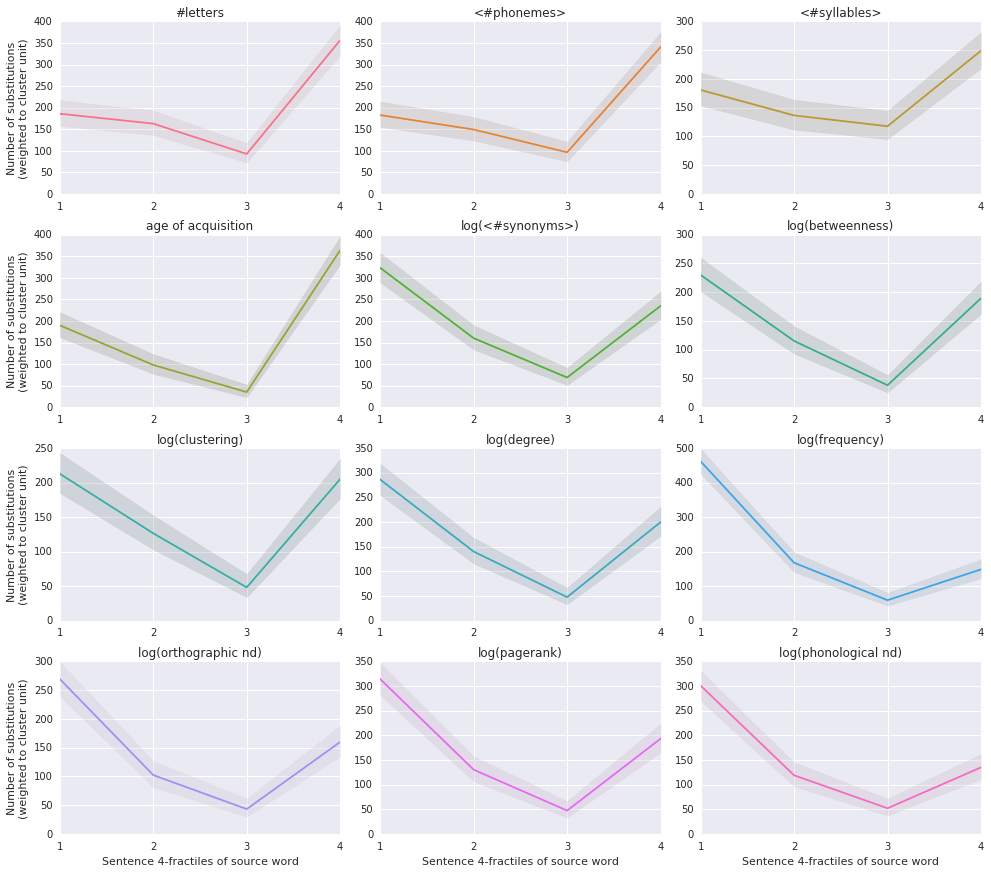

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

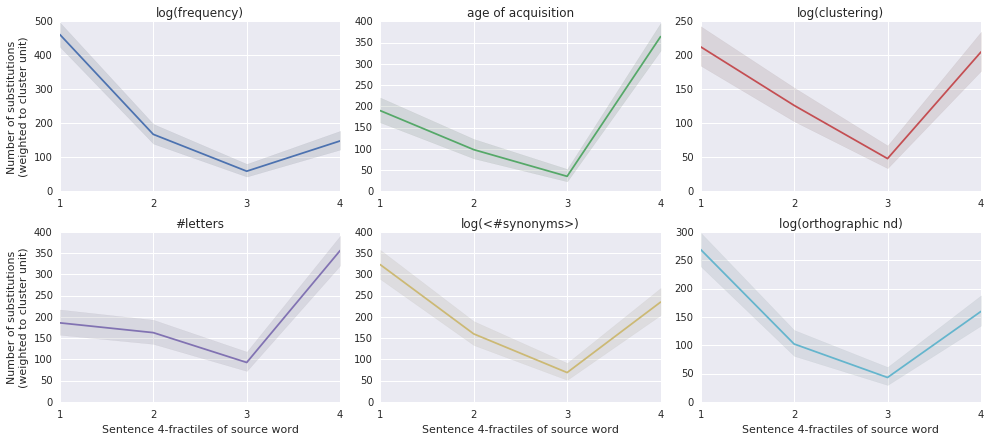

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)